In [ ]:
# import random
from collections import Counter
from pathlib import Path
from openai import OpenAI
import warnings
import IPython
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML, clear_output
import random
import warnings
import ipywidgets as widgets
import requests
import openai
warnings.filterwarnings('ignore')
import threading
import random
import pygame

# PASTE API KEYS HERE

user_input = "begin"
game_running = True

# Define character personalities
character_traits = {
    "Cowboy": "an old western gunslinger who loves whiskey and poker. Bluffing is his signature style.",
    "Businessman": "a messy businessman who calculates every move and weighs risks carefully.",
    "Robot": "a futuristic robot that plays only the correct play, following strict guidelines.",
    "Jester": "a wildcard who is unpredictable and full of tricks, using humor to disorient opponents."
}

# Simulate character selection
selected_character = input("Choose your character Personality! (Cowboy, Businessman, Robot, Jester): ").strip()
if selected_character not in character_traits:
    print("Invalid character selection. Please restart the game.")
else:
    character_text = character_traits[selected_character]
# Messages for the ChatGPT RPG instance
CHATGPT_POKER_MESSAGES = [
    {
        "role": "system",

        "content": "I want you to act as a poker player with the " + selected_character + "personality. Given their personality please take the input of a poker game state and respond with how you would like to procede. ONLY RETURN IN ONE OF 3 WAYS. 1. [Call] 2. [Fold] 3. [Raise:x] (where x is the integer number of chips you are raising). Only return in exactly that format and remember to adhere to that response strictly."
    }
]
CHATGPT_POKER_WIN_VOICELINES = [
    {
        "role": "system",

        "content": "I want you to act as a poker player with the " + selected_character + " personality. Given their personality please generate a voice line for whenever they would win the hand."
    }
]
CHATGPT_POKER_FOLD_VOICELINES = [
    {
        "role": "system",

        "content": "I want you to act as a poker player with the " + selected_character + " personality. Given their personality please generate a voice line for whenever they would fold."
    }
]
def get_fold_voiceline_from_gpt(game_state):
    CHATGPT_POKER_FOLD_VOICELINES.append(
        {
            "role" : "user",
            "content" : "give me a voiceline"
        }
    )

    completionVA = voiceClient.chat.completions.create(
        model="gpt-4o-mini",
        messages=CHATGPT_POKER_FOLD_VOICELINES,
        max_tokens=2048
    )

    # Append newest response to the chat array (context)
    message = completionVA.choices[0].message
    CHATGPT_POKER_FOLD_VOICELINES.append( message )

    # Return the message text to the game loop / user
    return message.content

def get_win_voiceline_from_gpt(game_state):
    CHATGPT_POKER_WIN_VOICELINES.append(
        {
            "role" : "user",
            "content" : "give me a voiceline"
        }
    )

    completionVA = voiceClient.chat.completions.create(
        model="gpt-4o-mini",
        messages=CHATGPT_POKER_WIN_VOICELINES,
        max_tokens=2048
    )

    # Append newest response to the chat array (context)
    message = completionVA.choices[0].message
    CHATGPT_POKER_FOLD_VOICELINES.append( message )

    # Return the message text to the game loop / user
    return message.content    

def show_audio_with_controls(file_path):
    display(HTML("<audio controls><source src={} type='audio/mpeg'></audio>".format(file_path)))
    
def send_gamestate_to_chatgpt(game_state):

    # Add user's last message to the chat array (context)
    CHATGPT_POKER_MESSAGES.append(
        {
            "role" : "user",
            "content" : game_state
        }
    )

    # Generate next 'Assistant' response by giving ChatGPT the entire history
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=CHATGPT_POKER_MESSAGES,
        max_tokens=2048
    )

    # Append newest response to the chat array (context)
    message = completion.choices[0].message
    CHATGPT_POKER_MESSAGES.append( message )

    # Return the message text to the game loop / user
    return message.content

# Define suits and ranks
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']
HAND_RANKS = [
    "High Card", "One Pair", "Two Pair", "Three of a Kind",
    "Straight", "Flush", "Full House", "Four of a Kind", "Straight Flush"
]

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

    def __repr__(self):
        return f"{self.rank} of {self.suit}"

class Deck:
    def __init__(self):
        self.cards = [Card(rank, suit) for suit in SUITS for rank in RANKS]
        random.shuffle(self.cards)

    def deal(self, num):
        return [self.cards.pop() for _ in range(num)]

def score_hand(cards):
    """Evaluate the best poker hand and return its rank and score."""
    def is_flush(cards):
        suits = [card.suit for card in cards]
        suit_counts = Counter(suits)
        for suit, count in suit_counts.items():
            if count >= 5:
                return True, [card for card in cards if card.suit == suit]
        return False, []

    def is_straight(cards):
        ranks = sorted(set(RANKS.index(card.rank) for card in cards), reverse=True)
        for i in range(len(ranks) - 4):
            if ranks[i] - ranks[i + 4] == 4:
                return True, ranks[i:i + 5]
        if set(ranks[-4:]) == {0, 1, 2, 3, 12}:  # Check for Ace-low straight
            return True, [3, 2, 1, 0, 12]
        return False, []

    def group_by_rank(cards):
        rank_counts = Counter(card.rank for card in cards)
        sorted_ranks = sorted(rank_counts.items(), key=lambda x: (-x[1], -RANKS.index(x[0])))
        return rank_counts, sorted_ranks

    def evaluate_hand(cards):
        flush, flush_cards = is_flush(cards)
        straight, straight_ranks = is_straight(cards)

        if flush and straight:
            flush_cards.sort(key=lambda c: RANKS.index(c.rank), reverse=True)
            straight_flush = [card for card in flush_cards if RANKS.index(card.rank) in straight_ranks]
            if len(straight_flush) >= 5:
                return "Straight Flush", straight_ranks[0]

        rank_counts, sorted_ranks = group_by_rank(cards)
        top_rank, top_count = sorted_ranks[0]

        # Four of a Kind
        if top_count == 4:
            return "Four of a Kind", [RANKS.index(top_rank), sorted_ranks[1][0]]

        # Full House
        if top_count == 3 and len(sorted_ranks) > 1 and sorted_ranks[1][1] >= 2:
            return "Full House", [RANKS.index(sorted_ranks[0][0]), RANKS.index(sorted_ranks[1][0])]

        # Flush
        if flush:
            top_flush = sorted(flush_cards, key=lambda c: RANKS.index(c.rank), reverse=True)[:5]
            return "Flush", [RANKS.index(card.rank) for card in top_flush]

        # Straight
        if straight:
            return "Straight", straight_ranks[0]

        # Three of a Kind
        if top_count == 3:
            return "Three of a Kind", [RANKS.index(top_rank)] + [RANKS.index(r[0]) for r in sorted_ranks[1:3]]

        # Two Pair
        if top_count == 2 and len(sorted_ranks) > 1 and sorted_ranks[1][1] == 2:
            return "Two Pair", [RANKS.index(r[0]) for r in sorted_ranks[:2]] + [RANKS.index(sorted_ranks[2][0])]

        # One Pair
        if top_count == 2:
            return "One Pair", [RANKS.index(top_rank)] + [RANKS.index(r[0]) for r in sorted_ranks[1:4]]

        # High Card
        top_five = sorted(cards, key=lambda c: RANKS.index(c.rank), reverse=True)[:5]
        return "High Card", [RANKS.index(card.rank) for card in top_five]

    cards.sort(key=lambda c: RANKS.index(c.rank), reverse=True)
    return evaluate_hand(cards)


class CharacterSelection:
    def __init__(self, callback):
        self.callback = callback  # Callback to notify PokerGame

    def generate_character_image(self, description):
        """Generate a character image using OpenAI's DALL·E."""
        try:
            response = imageClient.images.generate(
                prompt=description,
                n=1,
                size="256x256"
            )
            image_url = response.data[0].url  # Access the 'url' attribute of the first item
            return image_url
        except Exception as e:
            print(f"Error generating image: {e}")
            return None

    def display(self):
        """Display the character selection interface with names and images."""
        clear_output(wait=True)  # Clear previous outputs
        print("Loading Characters!")

        # Character definitions
        characters = {
            "Cowboy": {
                "description": "Yeehaw Partner!",
                "image_description": "A realistic picture of a cowboy, facing at you, ready for your next move playing poker."
            },
            "Businessman": {
                "description": "I have nothing to lose.",
                "image_description": "A realistic picture of a messy businessman with messy hair, facing at you, ready for your next move playing poker."
            },
            "Robot": {
                "description": "A gambling robot.",
                "image_description": "A realistic picture of a robot, facing at you, ready for your next move playing poker."
            },
            "Jester": {
                "description": "A wildcard!",
                "image_description": "A realistic picture of a jester, facing at you, ready for your next move playing poker."
            },
        }

        # Generate and display character options
        character_widgets = []
        for name, info in characters.items():
            print("Creating Character...")
            image_url = self.generate_character_image(info["image_description"])

            if not image_url:
                print(f"Failed to generate image for {name}. Skipping.")
                continue

            try:
                # Fetch the image content
                response = requests.get(image_url)
                response.raise_for_status()
                image_content = response.content

                # Create widgets
                image_widget = widgets.Image(
                    value=image_content,
                    format="png",  # Adjust if needed
                    width=150,
                    height=150,
                )

                # Combine image and name into a VBox
                vbox = widgets.VBox([
                    image_widget,
                    widgets.Label(name, style={"font-weight": "bold"}),  # Character name
                    widgets.Label(info["description"]),  # Character description
                ])
                character_widgets.append(vbox)

            except Exception as e:
                print(f"Error generating or rendering {name}: {e}")

        # Display all characters in a grid layout
        hbox = widgets.HBox(character_widgets)
        display(hbox)

        # Get user input
        selected_character = None
        while selected_character not in characters:
            print("Who will you choose between the Four?")
            selected_character = input("Enter your choice: ").strip()
            if selected_character not in characters:
                print("Invalid choice. Please type one of the character names exactly as shown.")

        # Notify callback with the selected character
        self.callback(selected_character)


    def on_character_selected(self, character_name):
        """
        Handle the character selection event.
        Notify the callback function with the selected character.
        """
        clear_output(wait=True)  # Clear the UI
        print(f"You selected: {character_name}")
        self.callback(character_name)  # Notify the main game


class PokerGame:
    def __init__(self, starting_tokens=100):
        self.starting_tokens = starting_tokens
        self.player_tokens = starting_tokens
        self.opponent_tokens = starting_tokens
        self.pot = 0
        self.player_current_bet = 0
        self.opponent_current_bet = 0
        self.hand_terminated = False
        self.selected_character = None
        self.character_selection = CharacterSelection(self.on_character_selected)

        pygame.mixer.init()

        self.character_music = {
            "Cowboy": ["cowpoke1.mp3", "cowpoke2.mp3", "cowpoke3.mp3", "cowpoke4.mp3"],
            "Businessman": ["businessman1.mp3", "businessman2.mp3", "businessman3.mp3", "businessman4.mp3"],
            "Robot": ["robot1.mp3", "robot2.mp3", "robot3.mp3", "robot4.mp3"],
            "Jester": ["jester1.mp3", "jester2.mp3", "jester3.mp3", "jester4.mp3"]
        }

    def play_random_music(self, character_name):
        """Play a random music file for the selected character."""
        if character_name in self.character_music:
            music_files = self.character_music[character_name]
            music_file = random.choice(music_files)  # Select a random file
            try:
                pygame.mixer.music.load(music_file)
                pygame.mixer.music.set_volume(0.5)
                pygame.mixer.music.play(-1)  # Loop indefinitely
                print(f"Playing {music_file} for {character_name}.")
            except pygame.error as e:
                print(f"Error playing music for {character_name}: {e}")
        else:
            print(f"No music available for character: {character_name}")

    def stop_background_music(self):
        """Stop the background music."""
        pygame.mixer.music.stop()


    def on_character_selected(self, character_name):
        """Handle character selection and start the game."""
        print(f"Character '{character_name}' selected in PokerGame.")
        self.selected_character = character_name
        self.play()  # Start the game

    def get_gamestate(self):
        gamestate = "your tokens: " + self.opponent_tokens + ", opponent tokens: " + self.player_tokens + ", total pot size: " + self.pot + ", opponent's current bet: " + self.player_current_bet + ", your cards: " + self.opponent_hand + ", current comunity cards: " + self.community_cards
        return(gamestate)

    def reset_round(self):
        """Reset the game state for a new round, including blinds."""
        if self.player_tokens < 10 or self.opponent_tokens < 10:
            print("Insufficient tokens to continue. Game over!")
            return False

        self.deck = Deck()
        self.community_cards = []
        self.player_hand = []
        self.opponent_hand = []
        self.pot = 0
        self.player_current_bet = 0
        self.opponent_current_bet = 0
        self.hand_terminated = False

        # Collect blinds
        blind = 10
        self.player_tokens -= blind
        self.opponent_tokens -= blind
        self.pot += blind * 2
        self.player_current_bet = blind
        self.opponent_current_bet = blind

        print(f"Both players placed a blind of {blind} tokens.")
        print(f"Pot starts at {self.pot} tokens.")
        return True

    def player_action(self):
        """Manage player's decision during their turn."""
        while not self.hand_terminated:
            print(f"Your tokens: {self.player_tokens}, Pot: {self.pot}")
            print(f"Opponent's current bet: {self.opponent_current_bet}")

            # Show actions based on the current betting state
            if self.player_current_bet < self.opponent_current_bet:
                print("Actions: [1] Call, [2] Raise, [3] Fold")
            else:
                print("Actions: [1] Call, [2] Raise, [3] Fold")

            # Get player's choice
            choice = input("Your choice: ").strip()
            if choice == "1":
                return self.call_bet()
            elif choice == "2":
                return self.raise_bet()
            elif choice == "3":
                return self.fold_hand()

            # Invalid input handling
            print("Invalid choice. Please try again.")

    def call_bet(self):
        """Handle player calling the current bet."""
        call_amount = self.opponent_current_bet - self.player_current_bet
        if call_amount > self.player_tokens:
            print("Not enough tokens to call. You fold.")
            return self.fold_hand()
        self.player_tokens -= call_amount
        self.player_current_bet += call_amount
        self.pot += call_amount
        print(f"You called with {call_amount} tokens.")
        return "Call"

    def raise_bet(self):
        """Handle player raising the bet."""
        while not self.hand_terminated:
            min_raise = max(1, self.opponent_current_bet - self.player_current_bet + 1)
            try:
                raise_amount = int(input(f"Enter your raise amount (minimum {min_raise}): "))
                if raise_amount < min_raise:
                    print(f"Raise must be at least {min_raise}.")
                elif raise_amount > self.player_tokens:
                    print("Not enough tokens to raise that amount.")
                else:
                    additional_raise = raise_amount - self.player_current_bet
                    self.player_tokens -= additional_raise
                    self.player_current_bet = raise_amount
                    self.pot += additional_raise
                    print(f"You raised to {self.player_current_bet} tokens.")

                    # Handle opponent's response to the raise
                    opponent_action = self.opponent_action()
                    if opponent_action == "Call":
                        return "Raise"
                    elif opponent_action == "Raise":
                        return "Opponent Raise"
                    elif opponent_action == "Fold":
                        imageOutput = imageClient.images.generate(
                            prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                            n=2,
                            size="256x256"
                        )
                        response = requests.get(imageOutput.data[0].url)
                        image = Image.open(BytesIO(response.content))
                        display(image)
                        chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
                        responseVA = ttsClient.audio.speech.create(
                            model="tts-1",
                            voice="onyx",
                            input= str(chatgpt_responseVA)
                        )
                        responseVA.stream_to_file("foldVoiceline.mp3")
                        show_audio_with_controls("foldVoiceline.mp3")
                        self.end_hand(winner="Player")
                        return "Win"
            except ValueError:
                print("Invalid input. Please enter a number.")


    def fold_hand(self):
        """Handle folding the hand."""
        print("You folded. Opponent wins!")
        imageOutput = imageClient.images.generate(
            prompt= "Generate an image of a this character " + selected_character + " and how they would react when WINNING in a poker game",
            n=2,
            size="256x256"
        )
        response = requests.get(imageOutput.data[0].url)
        image = Image.open(BytesIO(response.content))
        display(image)
        chatgpt_responseVA = get_win_voiceline_from_gpt(str(self.get_gamestate))
        responseVA = ttsClient.audio.speech.create(
            model="tts-1",
            voice="onyx",
            input= str(chatgpt_responseVA)
        )
        responseVA.stream_to_file("winVoiceline.mp3")
        show_audio_with_controls("winVoiceline.mp3")
        self.end_hand(winner="Opponent")
        return "Fold"

    def opponent_action(self):
        """Simulate the opponent's decision."""
        if self.hand_terminated:
            return "Fold"

        if self.opponent_current_bet < self.player_current_bet:
            chatgpt_response = send_gamestate_to_chatgpt(str(self.get_gamestate))
            print("Game: ", chatgpt_response)
            decision = chatgpt_response[1:-1]
            if decision == "Call":
                call_amount = self.player_current_bet - self.opponent_current_bet
                if call_amount > self.opponent_tokens:
                    print("Opponent doesn't have enough tokens to call and folds.")
                    imageOutput = imageClient.images.generate(
                        prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                        n=2,
                        size="256x256"
                    )
                    response = requests.get(imageOutput.data[0].url)
                    image = Image.open(BytesIO(response.content))
                    display(image)
                    chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
                    responseVA = ttsClient.audio.speech.create(
                        model="tts-1",
                        voice="onyx",
                        input= str(chatgpt_responseVA)
                    )
                    responseVA.stream_to_file("foldVoiceline.mp3")
                    show_audio_with_controls("foldVoiceline.mp3")
                    self.end_hand(winner="Player")
                    return "Fold"
                self.opponent_tokens -= call_amount
                self.opponent_current_bet += call_amount
                self.pot += call_amount
                print(f"Opponent calls {call_amount} tokens.")
                return "Call"
            elif decision.find(':') != -1:
                raiseAmount = decision.split(':')
                raiseAmountInt = int(raiseAmount[1])
                return self.opponent_raise(raiseAmountInt)
            else:
                print("Opponent folds.")
                imageOutput = imageClient.images.generate(
                    prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                    n=2,
                    size="256x256"
                )
                response = requests.get(imageOutput.data[0].url)
                image = Image.open(BytesIO(response.content))
                display(image)
                chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
                responseVA = ttsClient.audio.speech.create(
                    model="tts-1",
                    voice="onyx",
                    input= str(chatgpt_responseVA)
                )
                responseVA.stream_to_file("foldVoiceline.mp3")
                show_audio_with_controls("foldVoiceline.mp3")
                self.end_hand(winner="Player")
                return "Fold"
        else:
            chatgpt_response = send_gamestate_to_chatgpt(str(self.get_gamestate))
            print("Game: ", chatgpt_response)
            decision = chatgpt_response[1:-1]
            if decision == "Call":
                print("Opponent Calls")
                return "Call"
            elif decision == "Fold":
                imageOutput = imageClient.images.generate(
                    prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                    n=2,
                    size="256x256"
                )
                response = requests.get(imageOutput.data[0].url)
                image = Image.open(BytesIO(response.content))
                chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
                responseVA = ttsClient.audio.speech.create(
                    model="tts-1",
                    voice="onyx",
                    input= str(chatgpt_responseVA)
                )
                responseVA.stream_to_file("foldVoiceline.mp3")
                show_audio_with_controls("foldVoiceline.mp3")
                display(image)
                return "Fold"
            else:
                raiseAmount = decision.split(':')
                raiseAmountInt = int(raiseAmount[1])
                return self.opponent_raise(raiseAmountInt)

    def opponent_raise(self, raiseX):
        if self.hand_terminated:
            return "Fold"

        min_raise = self.player_current_bet + 1
        if self.opponent_tokens <= min_raise:
            print("Opponent doesn't have enough tokens to raise and folds.")
            imageOutput = imageClient.images.generate(
                prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                n=2,
                size="256x256"
            )
            response = requests.get(imageOutput.data[0].url)
            image = Image.open(BytesIO(response.content))
            display(image)
            chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
            responseVA = ttsClient.audio.speech.create(
                model="tts-1",
                voice="onyx",
                input= str(chatgpt_responseVA)
            )
            responseVA.stream_to_file("foldVoiceline.mp3")
            show_audio_with_controls("foldVoiceline.mp3")
            self.end_hand(winner="Player")
            return "Fold"

        # Ensure the raise is valid
        raise_amount = raiseX
        additional_raise = raise_amount - self.opponent_current_bet
        self.opponent_tokens -= additional_raise
        self.opponent_current_bet = raise_amount
        self.pot += additional_raise
        print(f"Opponent raises to {self.opponent_current_bet} tokens.")

        # End opponent's turn after a raise
        return "Raise"

    def compare_hands(self):
        """Compare player and opponent hands and determine the winner."""
        player_best_hand = score_hand(self.player_hand + self.community_cards)
        opponent_best_hand = score_hand(self.opponent_hand + self.community_cards)

        print(f"Your best hand: {player_best_hand[0]} with ranks {player_best_hand[1]}")
        print(f"Opponent's best hand: {opponent_best_hand[0]} with ranks {opponent_best_hand[1]}")

        if HAND_RANKS.index(player_best_hand[0]) > HAND_RANKS.index(opponent_best_hand[0]):
            imageOutput = imageClient.images.generate(
                prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                n=2,
                size="256x256"
            )
            response = requests.get(imageOutput.data[0].url)
            image = Image.open(BytesIO(response.content))
            display(image)
            chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
            responseVA = ttsClient.audio.speech.create(
                model="tts-1",
                voice="onyx",
                input= str(chatgpt_responseVA)
            )
            responseVA.stream_to_file("foldVoiceline.mp3")
            show_audio_with_controls("foldVoiceline.mp3")
            self.end_hand(winner="Player")
        elif HAND_RANKS.index(player_best_hand[0]) < HAND_RANKS.index(opponent_best_hand[0]):
            imageOutput = imageClient.images.generate(
                prompt= "Generate an image of a this character " + selected_character + " and how they would react when WINNING in a poker game",
                n=2,
                size="256x256"
            )
            response = requests.get(imageOutput.data[0].url)
            image = Image.open(BytesIO(response.content))
            display(image)
            chatgpt_responseVA = get_win_voiceline_from_gpt(str(self.get_gamestate))
            responseVA = ttsClient.audio.speech.create(
                model="tts-1",
                voice="onyx",
                input= str(chatgpt_responseVA)
            )
            responseVA.stream_to_file("winVoiceline.mp3")
            show_audio_with_controls("winVoiceline.mp3")
            self.end_hand(winner="Opponent")
        else:
            # Tie-breaking logic
            if player_best_hand[1] > opponent_best_hand[1]:
                imageOutput = imageClient.images.generate(
                    prompt= "Generate an image of a this character " + selected_character + " and how they would react when FOLDING in a poker game",
                    n=2,
                    size="256x256"
                )
                response = requests.get(imageOutput.data[0].url)
                image = Image.open(BytesIO(response.content))
                display(image)
                chatgpt_responseVA = get_fold_voiceline_from_gpt(str(self.get_gamestate))
                responseVA = ttsClient.audio.speech.create(
                    model="tts-1",
                    voice="onyx",
                    input= str(chatgpt_responseVA)
                )
                responseVA.stream_to_file("foldVoiceline.mp3")
                show_audio_with_controls("foldVoiceline.mp3")
                self.end_hand(winner="Player")
            else:
                imageOutput = imageClient.images.generate(
                    prompt= "Generate an image of a this character " + selected_character + " and how they would react when WINNING in a poker game",
                    n=2,
                    size="256x256"
                )
                response = requests.get(imageOutput.data[0].url)
                image = Image.open(BytesIO(response.content))
                display(image)
                chatgpt_responseVA = get_win_voiceline_from_gpt(str(self.get_gamestate))
                responseVA = ttsClient.audio.speech.create(
                    model="tts-1",
                    voice="onyx",
                    input= str(chatgpt_responseVA)
                )
                responseVA.stream_to_file("winVoiceline.mp3")
                show_audio_with_controls("winVoiceline.mp3")
                self.end_hand(winner="Opponent")

    def end_hand(self, winner):
        """End the hand and award the pot to the winner."""
        self.hand_terminated = True
        if winner == "Player":
            print("You win the hand!")
            self.player_tokens += self.pot
        else:
            print("Opponent wins the hand!")
            self.opponent_tokens += self.pot
        self.pot = 0

    def play_round(self):
        """Play a full round of poker."""
        if not self.reset_round():
            return "Game Over"

        self.player_hand = self.deck.deal(2)
        self.opponent_hand = self.deck.deal(2)

        print(f"Your hand: {self.player_hand}")
        print("Opponent's hand is hidden.")

        for stage, num_cards in [("Flop", 3), ("Turn", 1), ("River", 1)]:
            if self.hand_terminated:
                break

            print(f"Dealing {stage}...")
            self.community_cards.extend(self.deck.deal(num_cards))
            print(f"Community cards: {self.community_cards}")
            print(f"Starting {stage} betting round...")

            self.player_current_bet = 0
            self.opponent_current_bet = 0

            while not self.hand_terminated:
                player_action = self.player_action()
                if player_action == "Fold":
                    self.end_hand("Opponent")
                    return

                opponent_action = self.opponent_action()
                if opponent_action == "Fold":
                    self.end_hand("Player")
                    return

                if self.player_current_bet == self.opponent_current_bet:
                    print("Bets are equal. Ending betting round.")
                    break

        if not self.hand_terminated:
            print("Comparing hands...")
            self.compare_hands()

    def start(self):
        """Start the game with character selection."""
        print("Welcome to Poker!")
        self.character_selection.display()  # Show text-based character selection
        
    def play(self):
        """Start the poker game."""
        # Main game 
        self.play_random_music(self.selected_character)
        print(f"Starting the game against {self.selected_character}!")
        while True:
            result = self.play_round()
            if result == "Game Over":
                self.stop_background_music()
                break
            print(f"Tokens - You: {self.player_tokens}, Opponent: {self.opponent_tokens}")
            if self.player_tokens <= 0:
                print("You're out of tokens! Game over.")
                self.stop_background_music()
                break
            if self.opponent_tokens <= 0:
                print("Opponent is out of tokens! You win!")
                self.stop_background_music()
                break
            play_again = input("Play another round? (y/n): ").strip().lower()
            self.stop_background_music()
            if play_again != "y":
                print(f"Thanks for playing! Final tokens: {self.player_tokens}")
                break
        self.stop_background_music()



# Start the game
if __name__ == "__main__":
    game = PokerGame()
    game.start()


Loading Characters!
Creating Character...
Creating Character...
Creating Character...
Creating Character...


Who will you choose between the Four?


Enter your choice:  Cowboy


Character 'Cowboy' selected in PokerGame.
Error playing music for Cowboy: No file 'cowpoke1.mp3' found in working directory 'C:\Users\P. Lovan\Desktop\GAIT-poker-main'.
Starting the game against Cowboy!
Both players placed a blind of 10 tokens.
Pot starts at 20 tokens.
Your hand: [King of Hearts, 6 of Spades]
Opponent's hand is hidden.
Dealing Flop...
Community cards: [8 of Hearts, 8 of Diamonds, 7 of Diamonds]
Starting Flop betting round...
Your tokens: 90, Pot: 20
Opponent's current bet: 0
Actions: [1] Call, [2] Raise, [3] Fold


You called with 0 tokens.
Game:  [Fold]


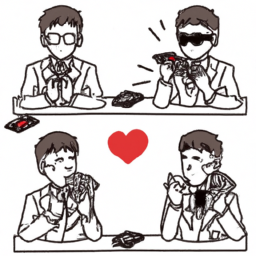

You win the hand!
Tokens - You: 110, Opponent: 90


Play another round? (y/n):  n


Thanks for playing! Final tokens: 110


In [ ]:
run gait.ipynb